In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm
from decoders import naiveBayes
import h5py

import config


In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'


# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()


In [ ]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [ ]:
# Number of Units without Whines
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 97):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



In [4]:
# Number of Units with Whines
unitNames = np.unique(dfDataBase['site']+'_'+ dfDataBase['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBase['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBase['stim'][dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)

191


In [5]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
# Use the following data if NW
#inPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'

inPath = rootPath+dataPath+'HerminaDataBase1UnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping  Use 13 if NW 12 otherwise.
indGood = np.argwhere(pcc > 12).flatten()
nGood = indGood.shape[0]

In [6]:
pccGood = pcc[indGood]
unitNamesGood = [unitNamesFull[i] for i in indGood]

indSort = np.flip(np.argsort(pccGood))

# Printing the name of the most discriminating units
birdName = []
for ind in indSort:
    print(unitNamesGood[ind], pccGood[ind])
    birdName.append(unitNamesGood[ind][0:4])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl 26.360434326725603
ZF7F_7t_190806_115742_goodPlayback-e13-c0.pkl 19.43376352108709
ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl 19.3922611150445
ZF4F_2t_190612_134337_goodPlayback-e16-c98.pkl 18.669185016155314
ZF4F_5t_190615_114154_goodPlayback-e20-c56.pkl 18.180298735672
ZF7F_5t_190720_152938_goodPlayback-e19-c65.pkl 17.986097749648305
ZF4F_2t_190613_101015.old_goodPlayback-e11-c62.pkl 17.741038436633367
ZF4F_7t_190619_095313_goodPlayback-e19-c49.pkl 17.316159758960968
ZF4F_6t_190616_142033_goodPlayback-e19-c38.pkl 17.230253782733975
ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl 17.05126138896764
ZF4F_3t_190613_150928_goodPlayback-e17-c97.pkl 16.907595803020097
ZF7F_7t_190806_115742_goodPlayback-e10-c65.pkl 16.82358990700664
ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl 16.576001372930396
ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl 16.180409934563144
ZF4F_2t_190612_134337_goodPlayback-e11-c27.pkl 16.03076077468061
ZF4F_2t_19061

In [7]:
# Decoding for a variable number of units.  For 1 and 2 - all permutations are done. 

# FIrst make the list of arguments so that the multiprocessing can be called out.
# We are doing 1,2,3,4,5,10,20

numUnits = 20
code = 'PC'
maxTest = 10000
mpflag = True


ntests = int(comb(nGood,numUnits))
if ntests > maxTest:
    ntests = maxTest
    

# Generate the list of arguments to run naiveBayes in parallel
argList = []
if numUnits == 1:
    for i, ind in enumerate(indGood):
        if i == ntests:
            break
        unitChoice = [unitNamesFull[ind]]
        argList.append(unitChoice)
elif numUnits == 2:  
    i = 0
    for i1, ind1 in enumerate(indGood):
        if i1 == ntests:
            break
        for i2, ind2 in enumerate(indGood):
            if i2 <= i1:
                continue
            if i2 == ntests:
                break
            unitChoice = [unitNamesFull[ind1], unitNamesFull[ind2]]
            argList.append(unitChoice)
            i += 1
else:
    unitNamesGood = np.array(unitNamesFull)[indGood]
    for i in range(ntests):
        unitChoice = np.random.choice(unitNamesGood, numUnits, replace=False)
        argList.append(unitChoice)

In [8]:
len(argList)

10000

In [9]:
# Run the decoders using multiprocessors if possible
ntests = len(argList)
mpflag = True

# Run Naive Bayes in chunks of 90 with a pool of 30 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all or 90 and 1800 tests.
poolSize = 30

# Allocate memory for results
pcc = np.zeros((ntests,))
selH = np.zeros((ntests,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = 0

# Calculate the number of chunks
nchunks = ntests//chunckSize
if nchunks % chunckSize:
    nchunks += 1
    
    
if mpflag == True:
    if __name__ == '__main__':
        for ichunk in range(nchunks):
            istart = ichunk*chunckSize
            iend = (ichunk+1)*chunckSize
            if iend > ntests:
                iend = ntests         
        
            with mp.Pool(poolSize) as p:
                results = p.map(naiveBayes, argList[istart:iend])
        
            # I don't think I need these??
            # p.close()
            # p.join()
        
            for i, res in enumerate(results):
                confMat = res[1]
                if (confMat.shape == (ncalls,ncalls) ):
                    pcc[istart + i] = res[0]
                    pccDiag = np.diag(confMat)
                    pccDiag = pccDiag/np.sum(pccDiag)
                    pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
                    selH[istart + i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
                    testsPerClass = res[2]
                    confMatTot = np.add(confMatTot, confMat)
                    confMatCount += testsPerClass
                
            print('Done with chunk %d/%d' % (ichunk, nchunks))
else:
    for i in range(ntests):
        pccval, confMat, testsPerClass = naiveBayes(argList[i])
        pcc[i] = pccval
        pccDiag = np.diag(confMat)
        pccDiag = pccDiag/np.sum(pccDiag)
        pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
        selH[i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
        confMatTot = np.add(confMatTot, confMat)
        confMatCount += testsPerClass

# Calculate the average confusion matrix. 
for i in range(ncalls):
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
        
# save the PC and Confusion matrices data base
outPath = rootPath+ dataPath + 'HerminaDataBase%dGoodUnitPC.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(confMatTot, fileOut)
pk.dump(pcc, fileOut)
pk.dump(selH, fileOut)
fileOut.close()




Done with chunk 0/100
Done with chunk 1/100
Done with chunk 2/100
Done with chunk 3/100
Done with chunk 4/100
Done with chunk 5/100
Done with chunk 6/100
Done with chunk 7/100
Done with chunk 8/100
Done with chunk 9/100
Done with chunk 10/100
Done with chunk 11/100
Done with chunk 12/100
Done with chunk 13/100
Done with chunk 14/100
Done with chunk 15/100
Done with chunk 16/100
Done with chunk 17/100
Done with chunk 18/100
Done with chunk 19/100
Done with chunk 20/100
Done with chunk 21/100
Done with chunk 22/100
Done with chunk 23/100
Done with chunk 24/100
Done with chunk 25/100
Done with chunk 26/100
Done with chunk 27/100
Done with chunk 28/100
Done with chunk 29/100
Done with chunk 30/100
Done with chunk 31/100
Done with chunk 32/100
Done with chunk 33/100
Done with chunk 34/100
Done with chunk 35/100
Done with chunk 36/100
Done with chunk 37/100
Done with chunk 38/100
Done with chunk 39/100
Done with chunk 40/100
Done with chunk 41/100
Done with chunk 42/100
Done with chunk 43/10

In [15]:
np.std(pcc)/np.sqrt(pcc.shape[0])

0.09412395033854346

In [17]:
np.mean(pcc)

42.28243905277367

In [16]:
np.std(pcc)/np.sqrt(100)

0.9412395033854345

In [19]:
np.std(pcc)/np.sqrt(pcc.shape[0]*0.05)

0.42093510253559496

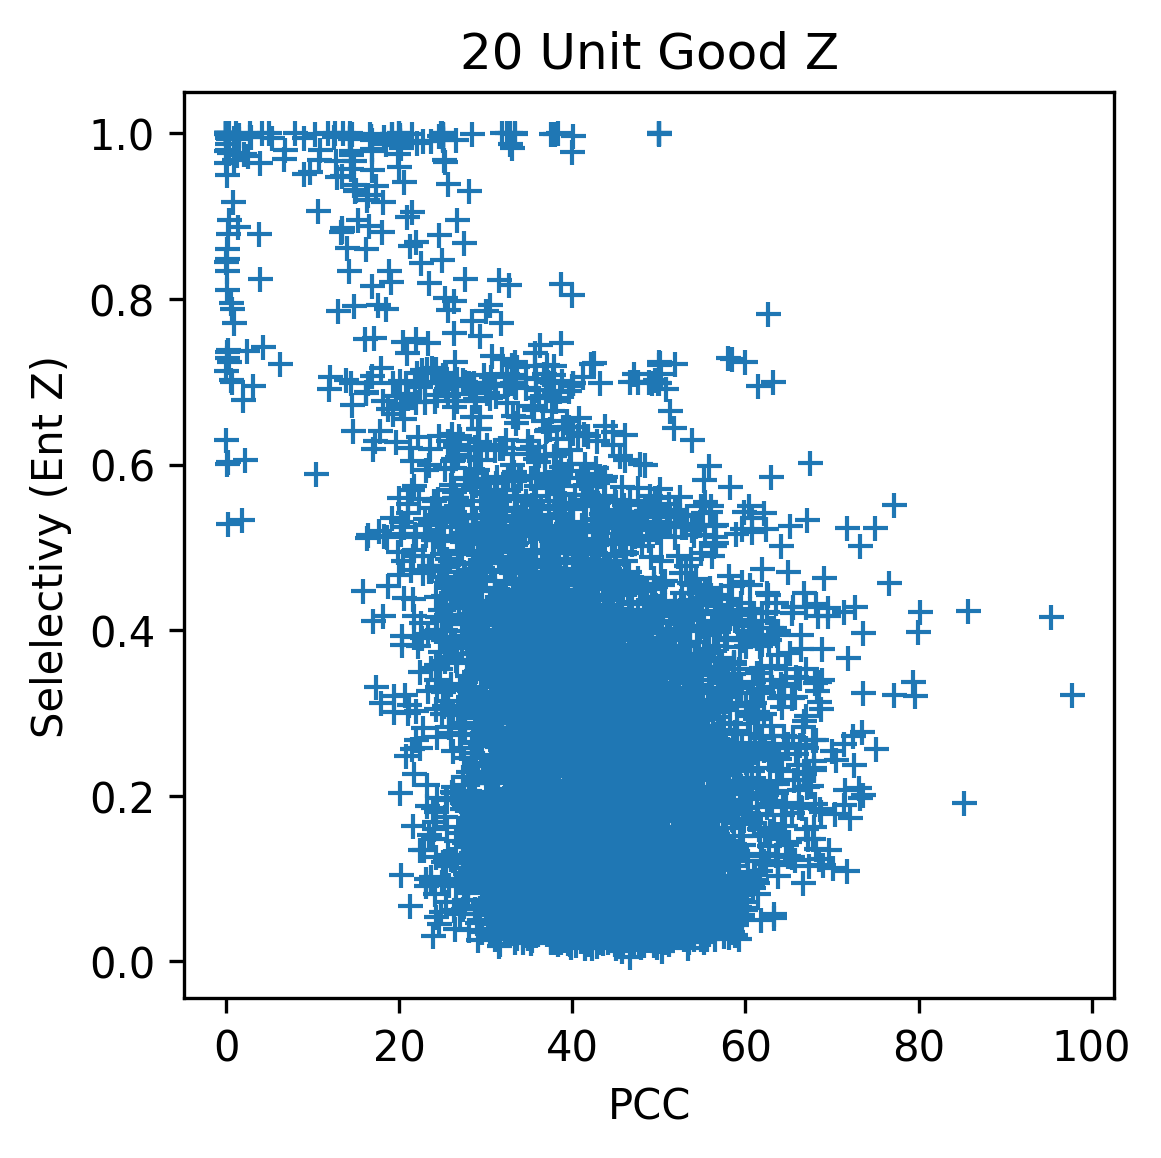

In [20]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.plot(pcc, selH, '+')

ax.set_xlabel('PCC')
ax.set_ylabel('Selelectivy (Ent Z)')
ax.set_title('%d Unit Good Z' % numUnits)

plt.savefig('/Users/frederictheunissen/Desktop/scatterPCCSelH%dUnitGoodZ.eps' % numUnits)

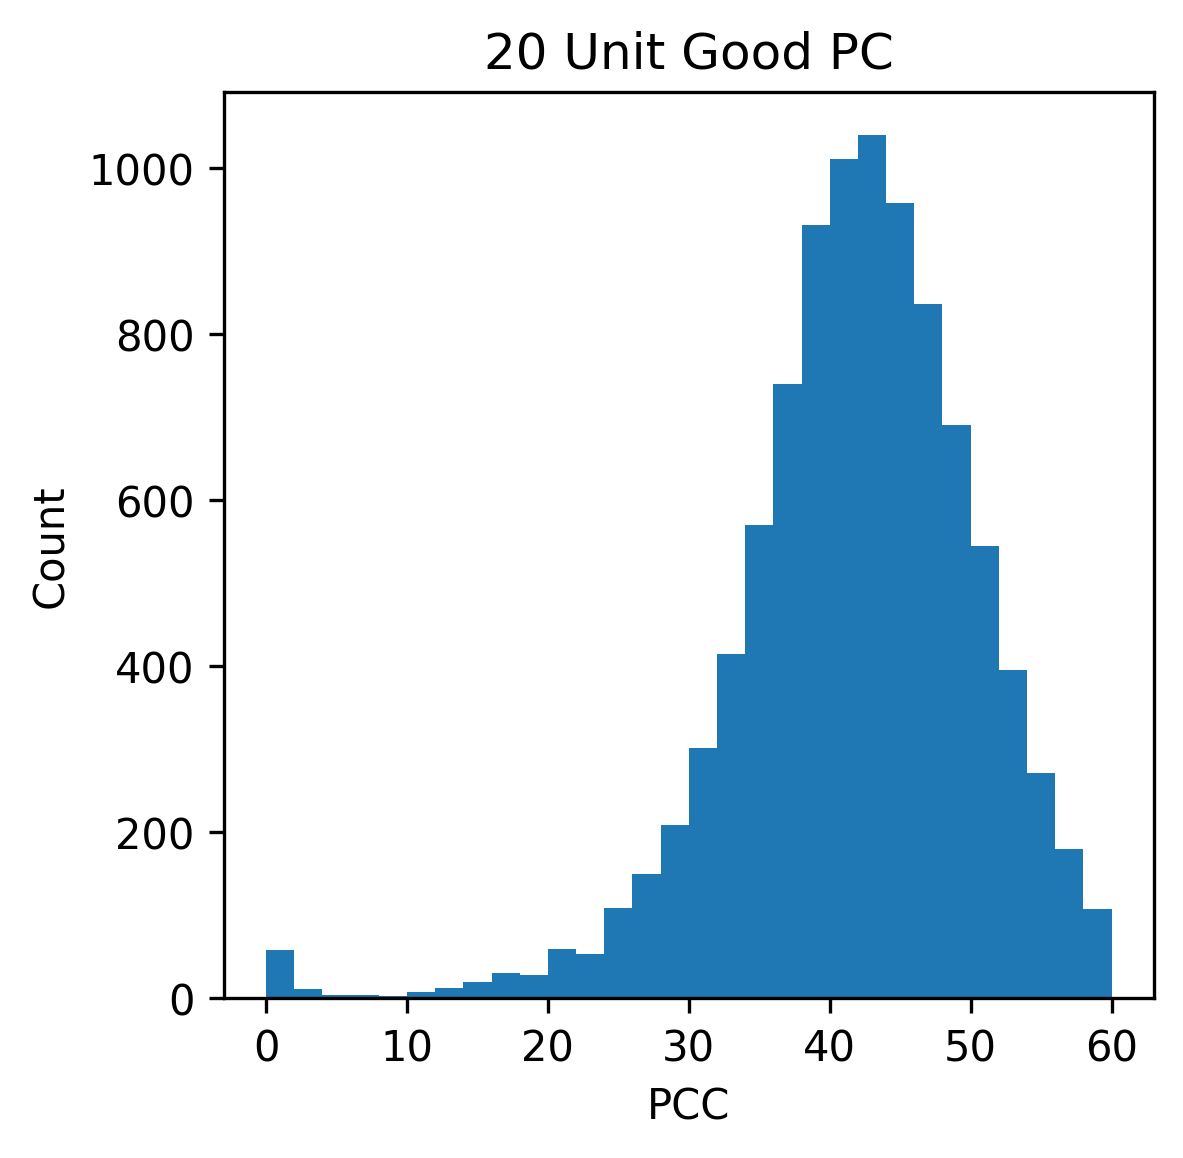

In [21]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.hist(pcc, bins = 30, range = (0,60))
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)

plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodZ.eps' % numUnits)

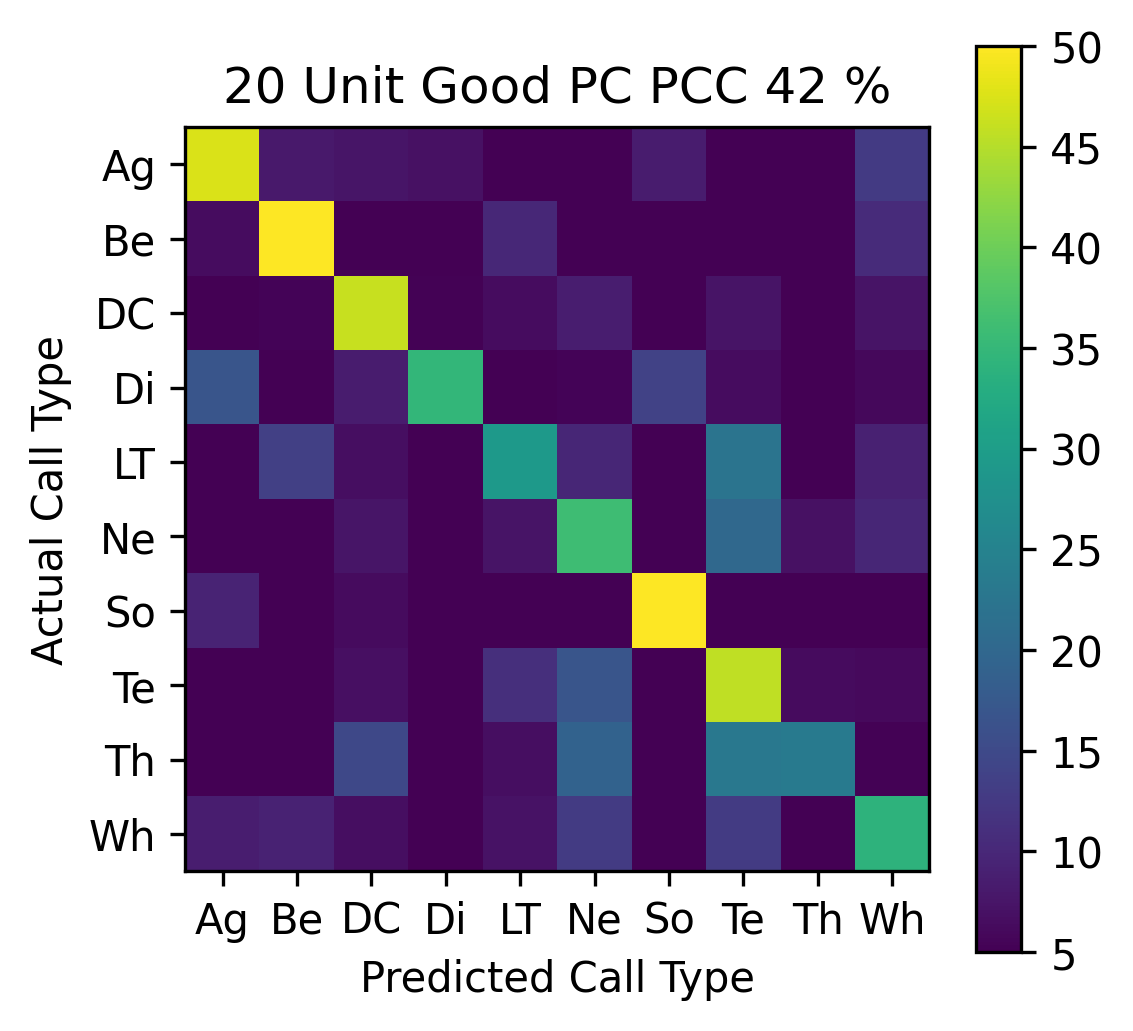

In [22]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()
im_ = ax.imshow(confMatTot*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 50)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%d Unit Good PC PCC %.0f %%' % (numUnits, np.mean(pcc)))

plt.savefig('/Users/frederictheunissen/Desktop/confMat%dUnitGoodZ.eps' % numUnits)


In [ ]:
# Comparing FET Naive Bayes to scikit learn Naive Bayes
numUnits = 20

# Read FET version
inPath = rootPath+ dataPath + 'HerminaDataBase%dGoodUnitPCFETV2.pkl' % numUnits
fileIn = open(inPath,"rb")
argListFET = pk.load(fileIn)
confMatTotFET = pk.load(fileIn)
pccFET = pk.load(fileIn)
fileIn.close()

# Read Scikit Version
inPath = rootPath+ dataPath + 'HerminaDataBase%dGoodUnitPC.pkl' % numUnits
fileIn = open(inPath,"rb")
argList = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()




In [ ]:

fig = plt.figure(figsize=(4,4), dpi=300)

ax = fig.subplots()

ax.hist([pcc, pccFET], bins = 100, range = (0,100), stacked = False)
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.legend(['Scikit', 'FET'])
ax.set_title('%d Unit Good PC' % numUnits)


plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodPCFETvsScikit.eps' % numUnits)